In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import load_config, seed_everything

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Customize Matplotlib parameters for consistency
plt.rcParams.update(config['plt_params'])

### Read files and take a first look

In [3]:
data_mat = pd.read_csv(config['paths']['data_mat_path'])
data_mat.head(5)

,sample,FT-000,FT-001,FT-002,FT-003,FT-004,FT-005,FT-006,FT-007,FT-008,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,20241106-297-Blank1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,20241106-297-Blank2,0.0,0.000000,0.0,5.770641,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.534493,0.0,0.0,0.0
2,20241106-297-Blank3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.469501,0.0,0.0,0.0
3,20241106-297-Blank4,0.0,5.497865,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,20241106-297-Blank5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
feat_meta = pd.read_csv(config['paths']['feat_meta_path'])
feat_meta.head(5)

,feature,mz,mz max,mz min,mz std,rt,rt end,rt max,rt min,rt start,rt std
0,FT-000,359.108768,359.130591,359.090122,0.010955,543.846374,561.270879,546.697803,539.941156,528.714227,1.683901
1,FT-001,357.109546,357.130018,357.091871,0.010668,543.839157,563.021530,546.948017,540.038924,528.530311,1.662290
2,FT-002,889.649931,889.702216,889.601547,0.025552,609.099742,627.717251,611.746501,606.426553,596.789046,1.324647
3,FT-003,355.111928,355.132772,355.093653,0.010508,543.995269,566.951285,547.164503,540.681882,526.943213,1.609071
4,FT-004,888.645365,888.696941,888.600202,0.026161,609.255652,632.996442,612.008732,606.778809,595.461688,1.254684


In [5]:
sample_meta = pd.read_csv(config['paths']['sample_meta_path'])
sample_meta.head(5)

,sample,class,id,order,batch
0,20241106-297-Blank1,B,20241106-297-Blank1,1,1
1,20241106-297-Blank2,B,20241106-297-Blank2,2,1
2,20241106-297-Blank3,B,20241106-297-Blank3,3,1
3,20241106-297-Blank4,B,20241106-297-Blank4,102,1
4,20241106-297-Blank5,B,20241106-297-Blank5,103,1


In [6]:
exog_stand = pd.read_csv(config['paths']['exog_stan_path'])
exog_stand

,compound_id,mz,Retention_time
0,GU4,886.40,610
1,GU5,1048.45,753
2,GU14,1253.96,1500
3,GU15,1334.99,1551


### Q1. How many features have been detected, how is the distribution across mz and retention time, and across classes?

In [7]:
print(f'Number of features: {data_mat.shape[1]-1}')
print(f'Number of samples: {data_mat.shape[0]}')

Number of features: 252
Number of samples: 124


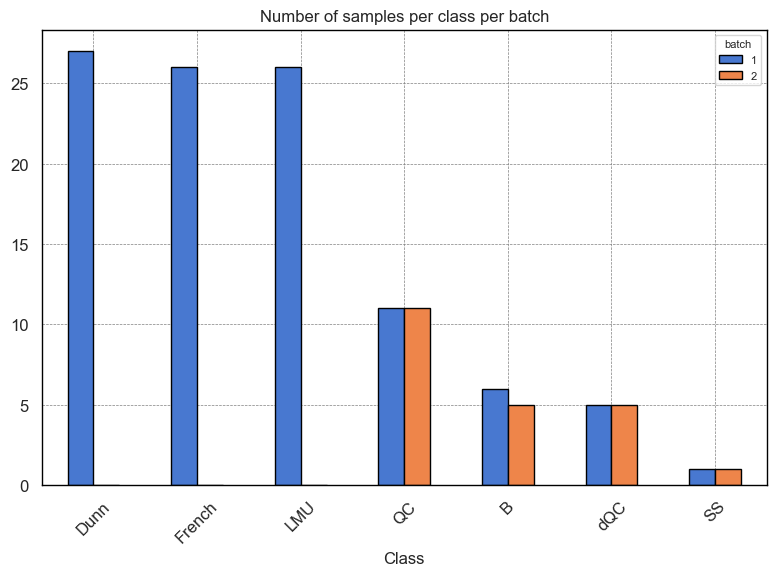

In [8]:
# Group and pivot the data
class_batch_counts = sample_meta.groupby(['class', 'batch']).size().unstack(fill_value=0)

# Sort by total count across batches
class_batch_counts['Total'] = class_batch_counts.sum(axis=1)
class_batch_counts = class_batch_counts.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot grouped bar plot
class_batch_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of samples per class per batch')
plt.xlabel('Class')
plt.legend(title='batch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

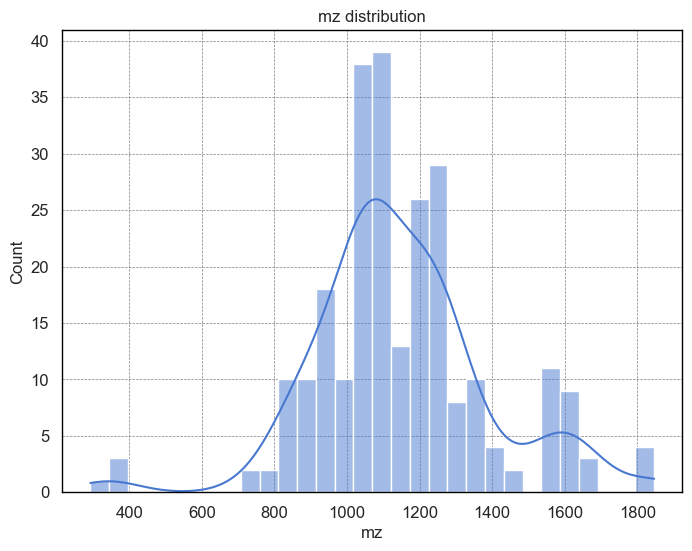

In [9]:
# mz distribution
plt.figure()
sns.histplot(feat_meta['mz'], kde=True, bins=30)
plt.title('mz distribution')
plt.xlabel('mz')
plt.show()

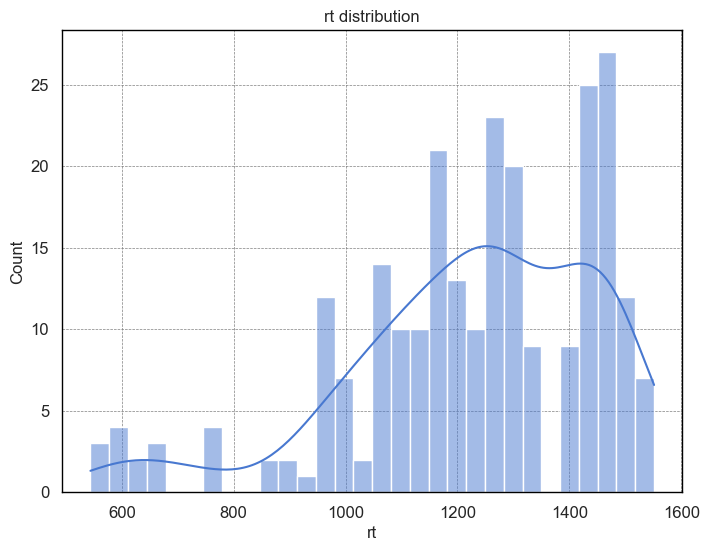

In [10]:
# rt distribution
plt.figure()
sns.histplot(feat_meta['rt'], kde=True, bins=30)
plt.title('rt distribution')
plt.xlabel('rt')
plt.show()

<Figure size 2000x1000 with 0 Axes>

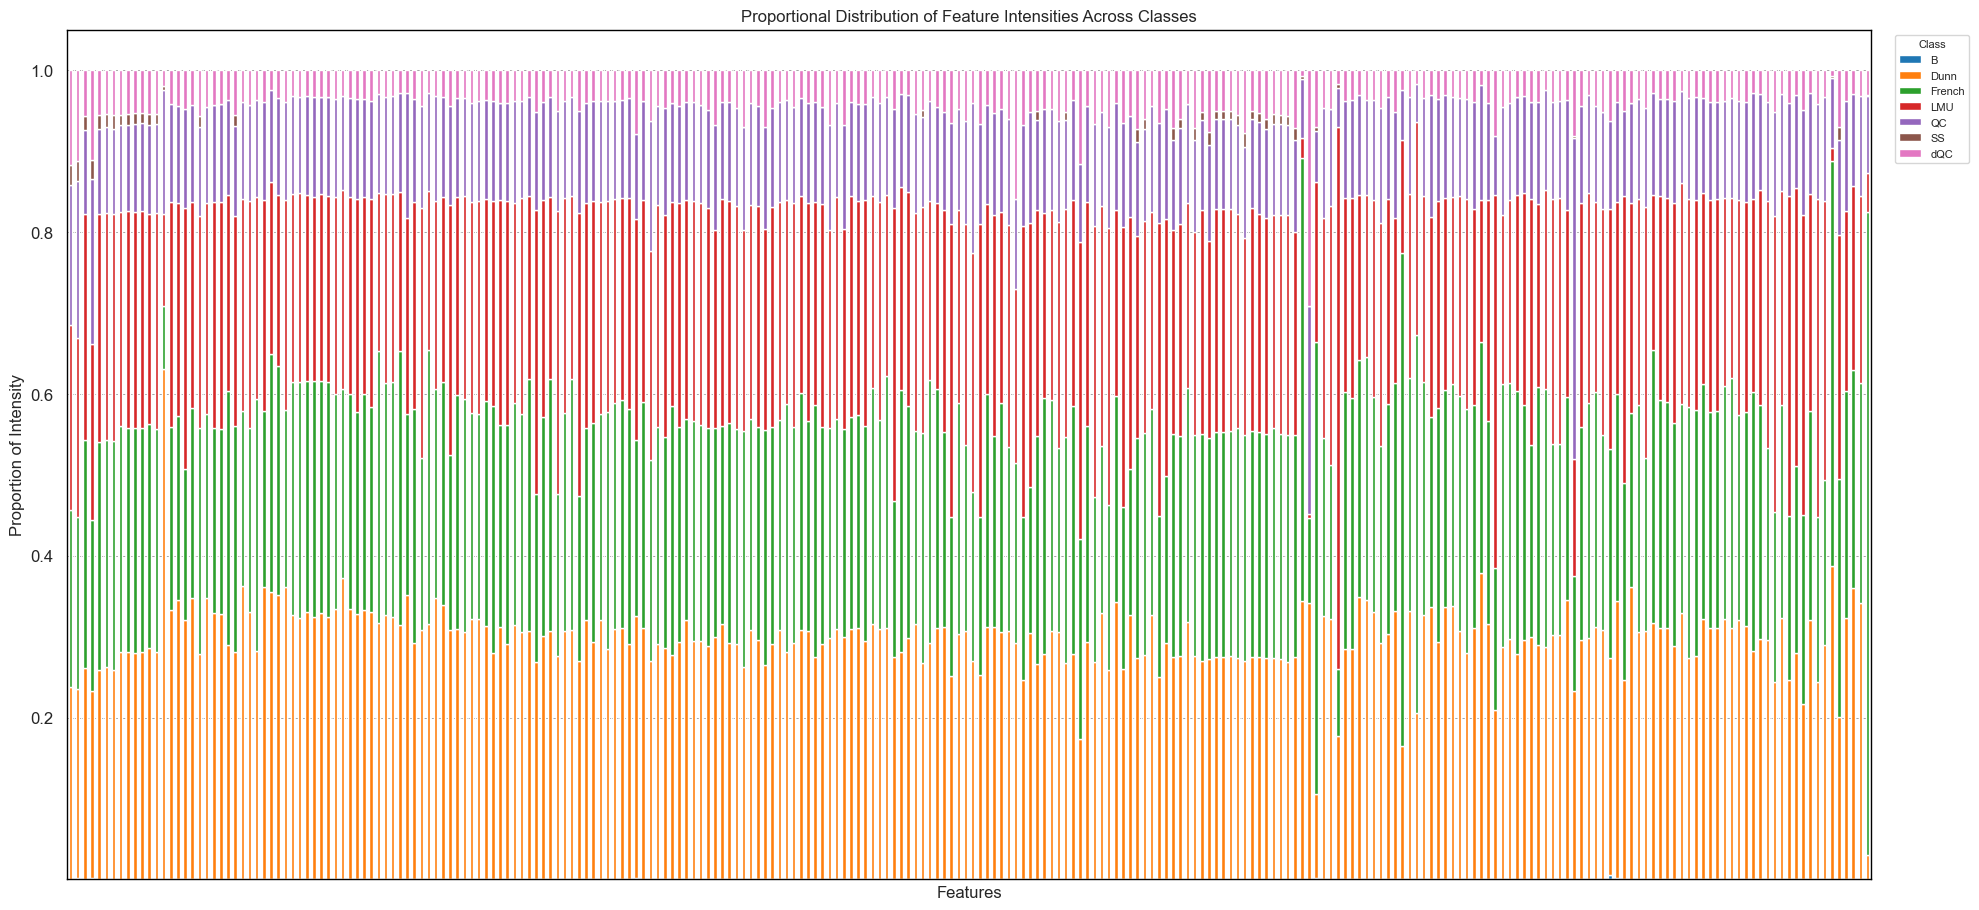

In [11]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')

# Replace zero intensities with NaN for presence/absence analysis
intensity_long['intensity'] = intensity_long['intensity'].replace(0, pd.NA)

# Calculate the total intensity for each feature by class
feature_class_intensity = intensity_long.groupby(['feature', 'class'])['intensity'].sum().unstack(fill_value=0)

# Calculate the proportion of intensity per class for each feature
feature_class_proportions = feature_class_intensity.div(feature_class_intensity.sum(axis=1), axis=0)

# Plot the proportional stacked bar plot
plt.figure(figsize=(20, 10))
feature_class_proportions.plot(kind='bar', stacked=True, figsize=(20, 10), color=sns.color_palette("tab10"))

plt.title('Proportional Distribution of Feature Intensities Across Classes')
plt.xlabel('Features')
plt.ylabel('Proportion of Intensity')
plt.legend(title='Class', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.xticks([]) 
plt.show()



### 2. How is the contamination in the experiment?

In [14]:
# extract Blank samples
data_mat_blank = data_mat.merge(sample_meta[['sample', 'class', 'batch']], how='left')
data_mat_blank = data_mat_blank[data_mat_blank['class'] == 'B']
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]
data_mat_blank_melt = data_mat_blank[ft_columns + ['sample', 'batch']].melt(id_vars=['sample', 'batch'], var_name='feature', value_name='intensity')


((6, 255), (5, 255))

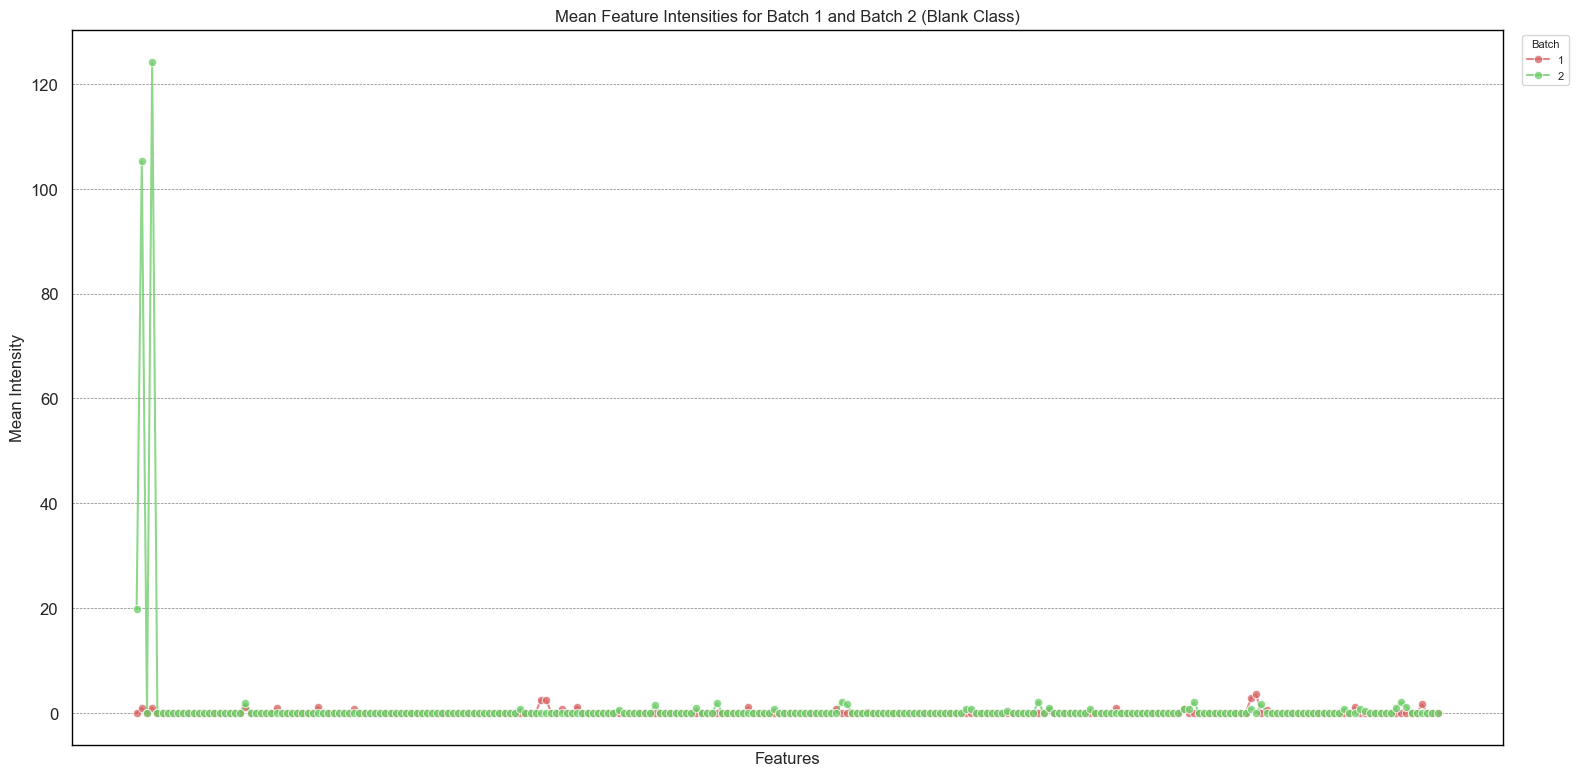

In [35]:
mean_intensities = data_mat_blank_melt.groupby(['feature', 'batch'])['intensity'].mean().reset_index()

plt.figure(figsize=(16, 8))
sns.lineplot(data=mean_intensities, x='feature', y='intensity', hue='batch', marker='o', alpha=0.75, palette=['r', 'g'])
plt.title('Mean Feature Intensities for Batch 1 and Batch 2 (Blank Class)')
plt.xlabel('Features')
plt.ylabel('Mean Intensity')
plt.xticks([])  
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

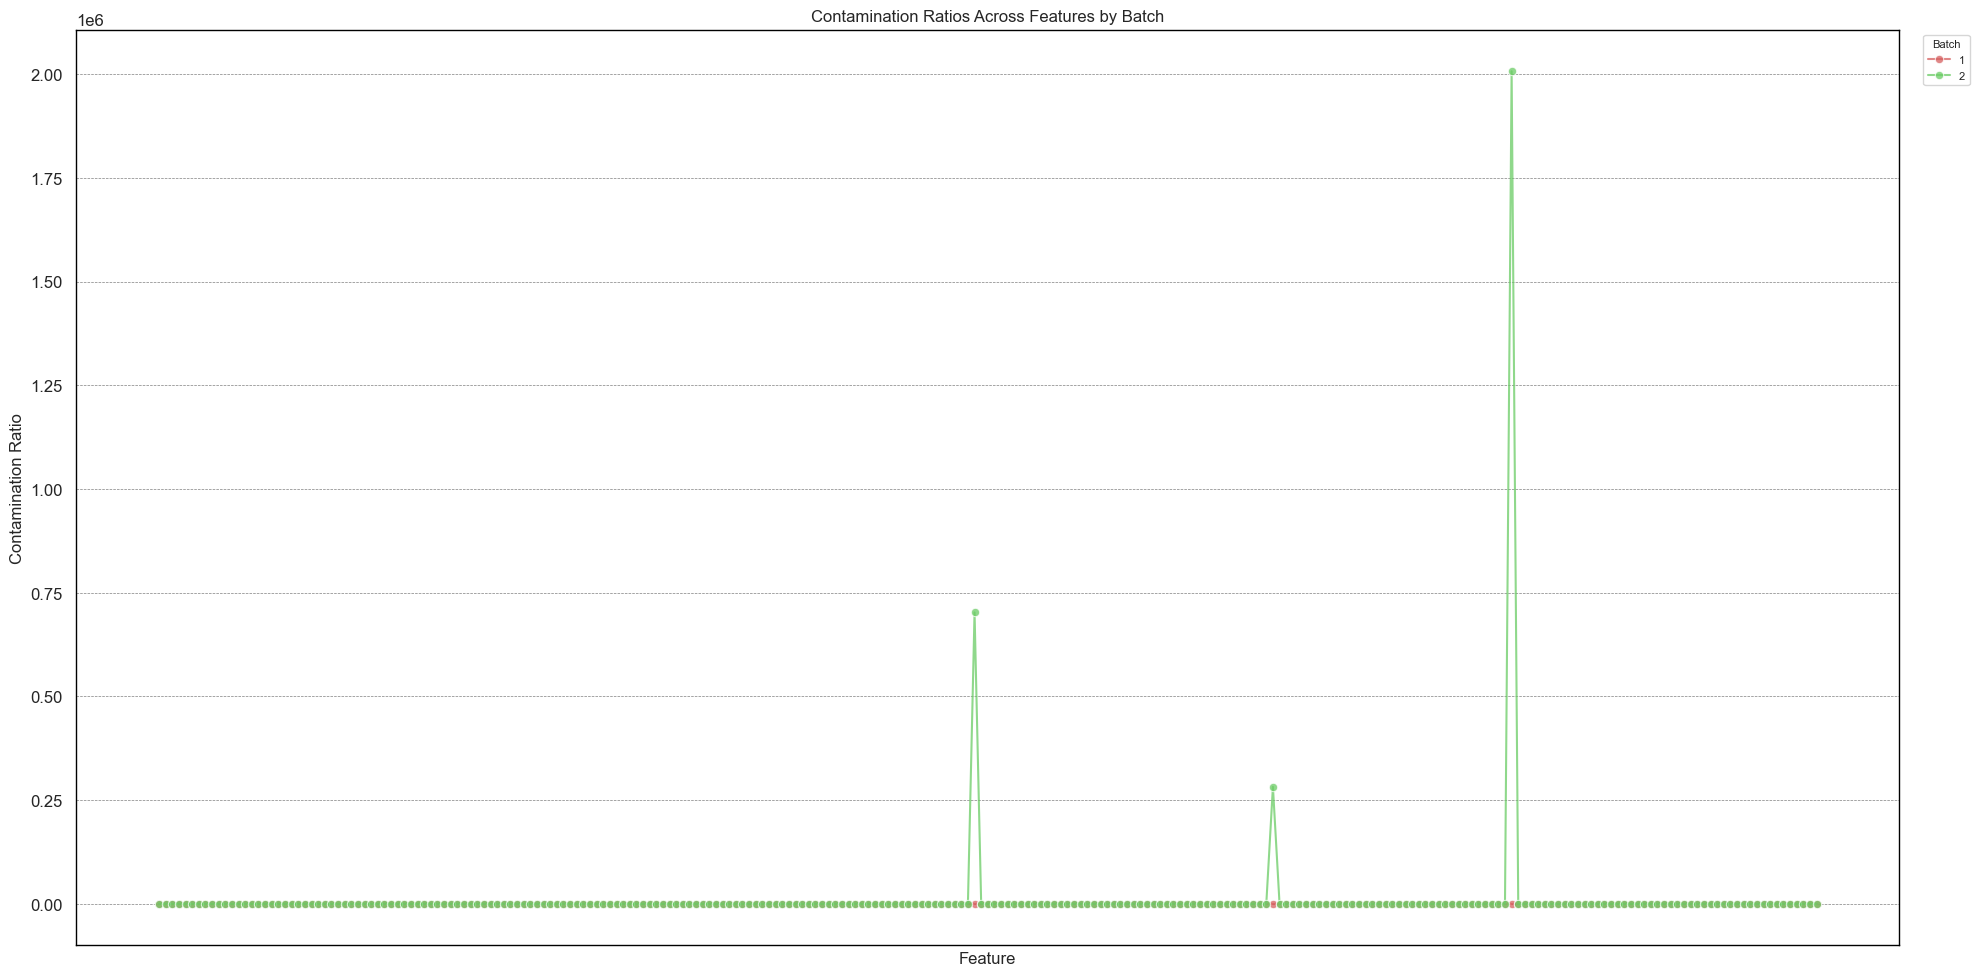

In [44]:
# Merge sample metadata with data_matrix
data_mat2 = data_mat.merge(sample_meta[['sample', 'class', 'batch']], on='sample', how='left')

# Create an empty DataFrame to store batch-level contamination ratios
batch_contamination_df = pd.DataFrame()

# Loop through each batch
for batch in data_mat2['batch'].unique():
    if pd.isna(batch):
        continue
    
    # Subset Blank and Non-Blank samples for the current batch
    blank_samples_batch = data_mat2[(data_mat2['class'].str.contains('B')) & (data_mat2['batch'] == batch)]
    non_blank_samples_batch = data_mat2[~(data_mat2['class'].str.contains('B')) & (data_mat2['batch'] == batch)]
    
    # Calculate mean intensity per feature
    blank_means_batch = blank_samples_batch.iloc[:, 1:-3].mean(axis=0)  # Exclude metadata columns
    non_blank_means_batch = non_blank_samples_batch.iloc[:, 1:-3].mean(axis=0)  # Exclude metadata columns
    
    # Create a temporary DataFrame for this batch
    contamination_batch = pd.DataFrame({
        'Feature': blank_samples_batch.columns[1:-3],
        f'Blank_Mean_Intensity_Batch_{batch}': blank_means_batch.values,
        f'Non_Blank_Mean_Intensity_Batch_{batch}': non_blank_means_batch.values,
    })
    
    # Calculate contamination ratio for this batch
    contamination_batch[f'Contamination_Ratio_Batch_{batch}'] = (
        contamination_batch[f'Blank_Mean_Intensity_Batch_{batch}'] / 
        (contamination_batch[f'Non_Blank_Mean_Intensity_Batch_{batch}'] + 1e-6)
    )
    
    # Merge batch data into the main contamination DataFrame
    if batch_contamination_df.empty:
        batch_contamination_df = contamination_batch
    else:
        batch_contamination_df = batch_contamination_df.merge(contamination_batch, on='Feature', how='outer')

# Prepare data for line plot visualization
# Melt the contamination DataFrame to long format for plotting
contamination_long = pd.melt(
    batch_contamination_df,
    id_vars='Feature',
    value_vars=[col for col in batch_contamination_df.columns if 'Contamination_Ratio' in col],
    var_name='Batch',
    value_name='Contamination_Ratio'
)

# Extract batch numbers for coloring
contamination_long['Batch'] = contamination_long['Batch'].str.extract(r'Batch_(\d+)').astype(int)

# Plot contamination ratios as a line plot, colored by batch
plt.figure(figsize=(20, 10))
sns.lineplot(
    data=contamination_long,
    x='Feature',
    y='Contamination_Ratio',
    hue='Batch',
    marker='o',
    palette=['r', 'g'],
    alpha=0.75
)
plt.title('Contamination Ratios Across Features by Batch')
plt.xlabel('Features')
plt.ylabel('Contamination Ratio')
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([]) 
plt.tight_layout()
plt.show()


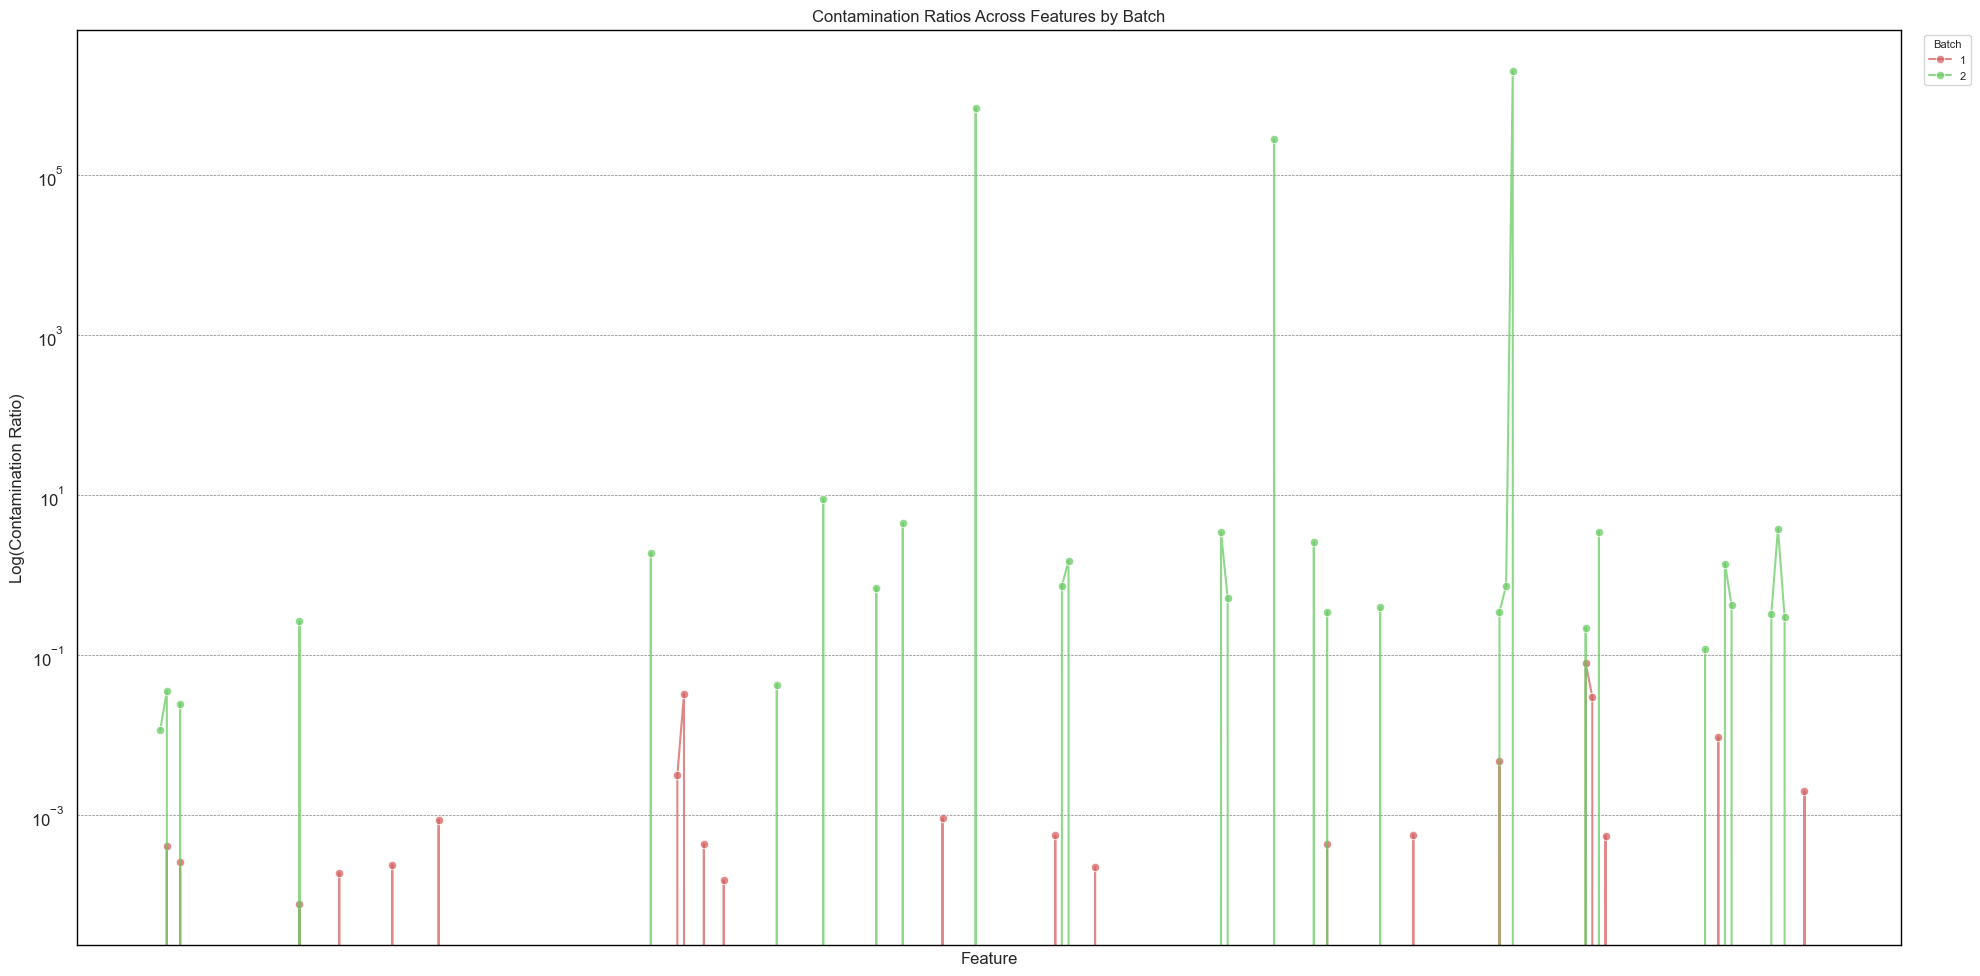

In [ ]:
# Plot contamination ratios as a line plot, colored by batch
plt.figure(figsize=(20, 10))
sns.lineplot(
    data=contamination_long,
    x='Feature',
    y='Contamination_Ratio',
    hue='Batch',
    marker='o',
    palette=['r', 'g'],
    alpha=0.75
)
plt.title('Contamination Ratios Across Features by Batch')
plt.xlabel('Features')
plt.ylabel('Log(Contamination Ratio)')
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([]) 
plt.tight_layout()
plt.yscale('log') 
plt.show()


In [42]:
batch_contamination_df

,Feature,Blank_Mean_Intensity_Batch_1,Non_Blank_Mean_Intensity_Batch_1,Contamination_Ratio_Batch_1,Blank_Mean_Intensity_Batch_2,Non_Blank_Mean_Intensity_Batch_2,Contamination_Ratio_Batch_2
0,FT-000,0.000000,1522.680520,0.000000,19.830326,1712.171081,0.011582
1,FT-001,0.916311,2231.127976,0.000411,105.232463,2912.872185,0.036127
2,FT-002,0.000000,1543.360837,0.000000,0.000000,19.345627,0.000000
3,FT-003,0.961773,3669.937901,0.000262,124.168061,4998.577644,0.024841
4,FT-004,0.000000,5416.023639,0.000000,0.000000,15.153690,0.000000
...,...,...,...,...,...,...,...
246,FT-246,0.000000,340.170648,0.000000,0.000000,0.000000,0.000000
247,FT-247,0.000000,1300.649472,0.000000,0.000000,0.464343,0.000000
248,FT-248,1.667332,838.728753,0.001988,0.000000,106.096901,0.000000
249,FT-249,0.000000,66.771586,0.000000,0.000000,0.000000,0.000000


In [38]:
batch_contamination_df

,Feature,Blank_Mean_Intensity_Batch_1,Non_Blank_Mean_Intensity_Batch_1,Contamination_Ratio_Batch_1,Blank_Mean_Intensity_Batch_2,Non_Blank_Mean_Intensity_Batch_2,Contamination_Ratio_Batch_2
0,FT-000,0.000000,1522.680520,0.000000,19.830326,1712.171081,0.011582
1,FT-001,0.916311,2231.127976,0.000411,105.232463,2912.872185,0.036127
2,FT-002,0.000000,1543.360837,0.000000,0.000000,19.345627,0.000000
3,FT-003,0.961773,3669.937901,0.000262,124.168061,4998.577644,0.024841
4,FT-004,0.000000,5416.023639,0.000000,0.000000,15.153690,0.000000
...,...,...,...,...,...,...,...
246,FT-246,0.000000,340.170648,0.000000,0.000000,0.000000,0.000000
247,FT-247,0.000000,1300.649472,0.000000,0.000000,0.464343,0.000000
248,FT-248,1.667332,838.728753,0.001988,0.000000,106.096901,0.000000
249,FT-249,0.000000,66.771586,0.000000,0.000000,0.000000,0.000000
